## 决策树与K近邻分类

##### 分别使用 决策树 和 最近邻方法在分类任务上构建模型， 并通过交叉验证对模型进行调优
- 决策树
- 最近邻方法
- 交叉验证

> 机器学习定义： 假设用 P 来评估计算机程序在某任务类 T 上的性能，若一个程序利用经验 E 在任务 T 上获得了性能改善，则我们就说关于 T 和 P, 该程序对 E 进行了学习。

> 经验 E 指的是数据（没有数据我们什么也干不了）。
>> 根据训练方式，机器学习算法可以分为监督（supervised）和无监督（unsupervised）两类。
- 无监督学习需要训练含有很多特征的数据集，然后学习出这个数据集上有用的结构性质。
-  监督学习的数据集除了含有很多特征外，它的每个样本都要有一个标签（label）或目标（target）。

#### 在不同的问题设定下，T、P、E 可能指完全不同的东西。机器学习中一些流行的任务 T 包括：
- 分类：基于特征将实例分为某一类。
- 回归：基于实例的其他特征预测该实例的数值型目标特征。
- 聚类：基于实例的特征实现实例的分组，从而让组内成员比组间成员更为相似。
- 异常检测：寻找与其他样本或组内实例有很大区别的实例。
- 其他更多任务

### 分类和回归，属于监督学习
#### 例如：
- 信贷机构 希望根据用户累积的数据预测贷款违约情况
 - 此时E 就是已有的训练数据，即实例（客户）的集合， 一组特征（如：年龄、薪水、贷款类型、以往的违约记录） ； 一个目标（是否会违约） ； 
 - 由于需预测的目标变量是---是否会违约，此时就是一个二分类问题
 - 如果转而预测 贷款会超期多久，目标变量---一个超期的连续时间，此时就是一个回归问题

### 决策树

#### 分类问题中其他的分割质量标准

- 基尼不确定性（Gini uncertainty）：$G = 1 - \sum\limits_k (p_k)^2$
- 错分率（Misclassification error）：$E = 1 - \max\limits_k p_k$

##### 二元分类问题的熵和基尼不确定性为：
 
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})}$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+)$$

- 其中 $p_+$ 是对象具有标签 + 的概率。
- 以 $p_+$ 为坐标，绘制上面两个函数的图像。

In [1]:
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
warnings.filterwarnings('ignore')

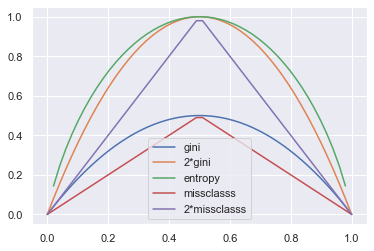

In [2]:
plt.figure(figsize=(6,4))
xx = np.linspace(0,1,50)
plt.plot(xx,[2 * x * (1-x) for x in xx] ,label='gini')
plt.plot(xx,[4 * x * (1-x) for x in xx] ,label='2*gini')
plt.plot(xx,[-x * np.log2(x) - (1-x)*np.log2(1-x)  for x in xx] ,label='entropy')
plt.plot(xx,[1-max(x,1-x) for x in xx] ,label='missclasss')
plt.plot(xx,[2-2* max(x,1-x) for x in xx] ,label='2*missclasss')
plt.legend()

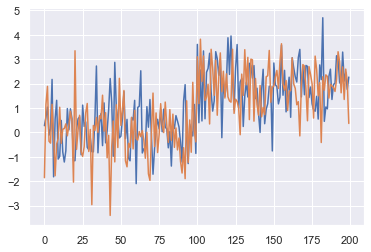

In [3]:
# 使用决策树拟合一些合成数据
## 第一类
np.random.seed(17)
train_data = np.random.normal(size=(100,2))
train_data
train_labels = np.zeros(100)
train_labels

## 第二类
train_data = np.r_[train_data, np.random.normal(size=(100,2), loc=2)]
train_labels = np.r_[train_labels,np.ones(100)]
train_labels
plt.plot(train_data)

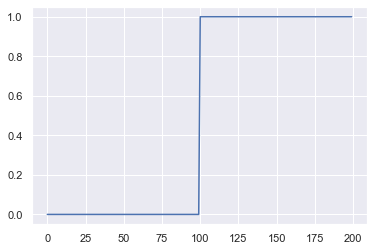

In [4]:
plt.plot(train_labels)

##### 为分类问题构造一个边界， 能较好的分开两个类别（红点、黄点）

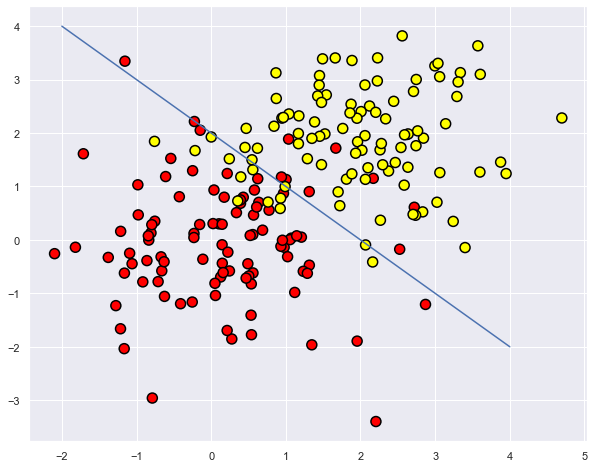

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(
    train_data[:,0], train_data[:,1], c= train_labels, s=100, cmap='autumn' , edgecolors='black' , linewidth=1.5
)
plt.plot(range(-2,5), range(4,-3,-1))

In [21]:
train_data.shape

(200, 2)

##### 训练一颗sklearn决策树， 区分两类数据点 ， 最后可视化所得的边界

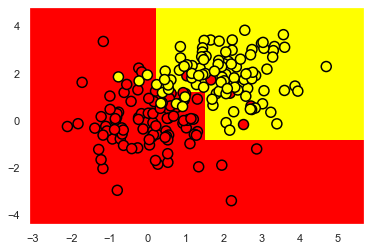

In [22]:
from sklearn.tree import DecisionTreeClassifier

def get_grid(data):
    x_min, x_max = data[:,0].min()-1 , data[:,0].max()+1
    y_min, y_max = data[:,1].min()-1 , data[:,1].max()+1
    return np.meshgrid(np.arange(x_min,x_max,0.01), np.arange(y_min,y_max,0.01))

# max_depth参数限制决策树的深度
clf_tree = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=17)

# 训练决策树
clf_tree.fit(train_data,train_labels)

# 可视化
xx,yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx,yy,predicted, cmap='autumn')
plt.scatter(train_data[:,0],train_data[:,1], c=train_labels, s=100, cmap='autumn', edgecolors='black' ,linewidths=1.5)

- 通过 pydotplus 和 export_graphviz 库我们可以方便的看到决策树本身是怎样的。
- 使用 `StringIO()` 函数开辟一个缓存空间保存决策树，
- 通过 `export_graphviz()` 函数以 DOT 格式导出决策树的 GraphViz 表示，然后将其写入 out_file 中。
- 使用 `graph_from_dot_data()` 函数读入数据并通过 `Image()` 函数显示决策树。

In [25]:
!pip install ipywidgets -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 121 kB 601 kB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 240 kB/s eta 0:00:01


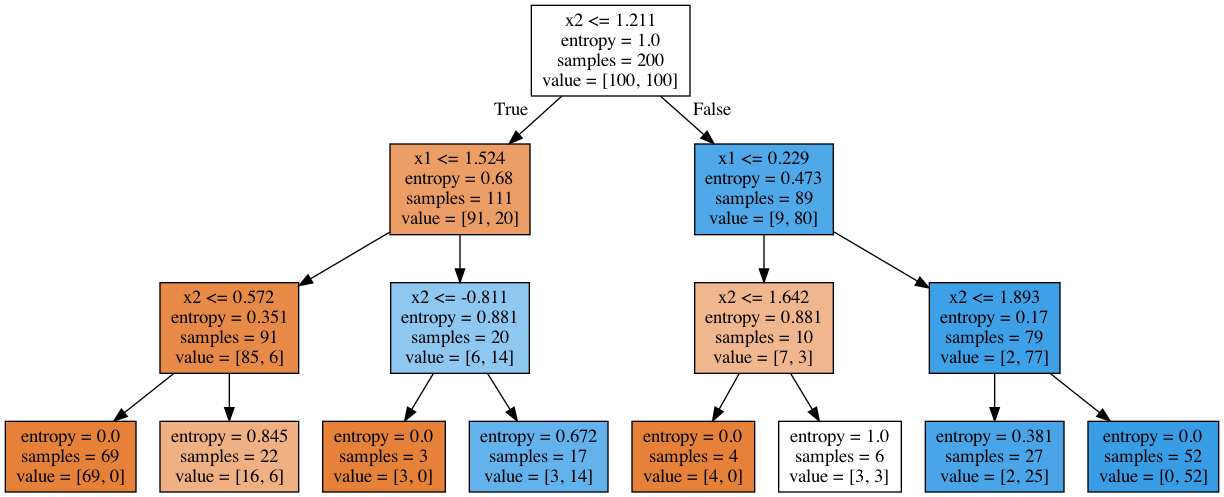

In [33]:
from io import StringIO
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree,feature_names=['x1','x2'],
                out_file= dot_data, filled=True
               )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### 决策树应用到数值特征

In [28]:
data = pd.DataFrame({'Age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
                     'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [29]:
data.sort_values('Age')

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [34]:
data['Age'].values.reshape(-1,1)

array([[17],
       [64],
       [18],
       [20],
       [38],
       [49],
       [55],
       [25],
       [29],
       [31],
       [33]])

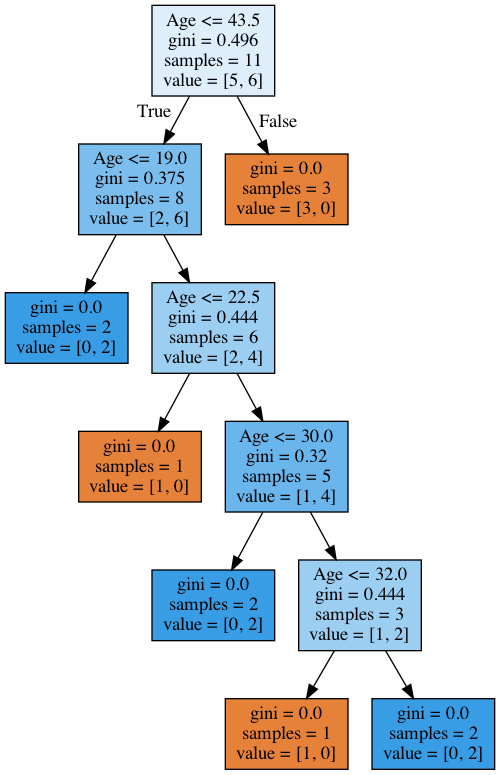

In [35]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Age'].values.reshape(-1,1), data['Loan Default'].values)

dot_data = StringIO()
export_graphviz(age_tree , feature_names=['Age'] , out_file = dot_data , filled=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [36]:
# 把「薪水」变量（以千美元每年为单位）加入数据集
data2 = pd.DataFrame({'Age':  [17, 64, 18, 20, 38, 49, 55, 25, 29, 31, 33],
                      'Salary': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102, 88],
                      'Loan Default': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]})
data2.sort_values('Age')

,Age,Salary,Loan Default
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [37]:
data2.sort_values('Salary')

,Age,Salary,Loan Default
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [38]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Age', 'Salary']].values, data2['Loan Default'].values)

DecisionTreeClassifier(random_state=17)

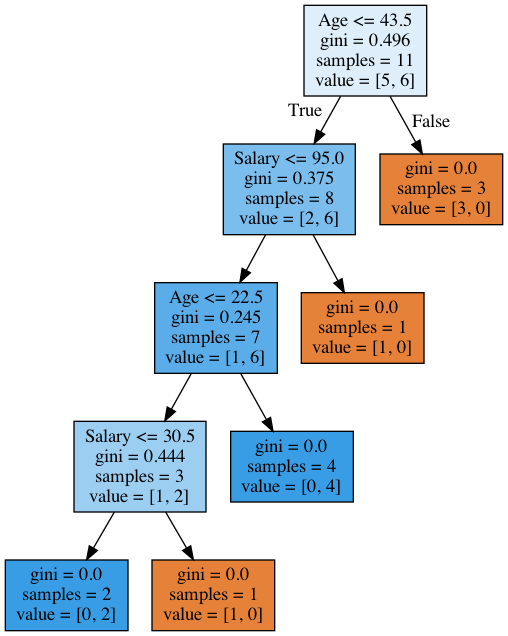

In [39]:
dot_data = StringIO()
export_graphviz(age_sal_tree, feature_names=['Age', 'Salary'],
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

- 结论：决策树处理数值特征最简单的启发式算法是升序排列它的值，然后只关注目标变量发生改变的那些值。

#### 树的关键参数

- 理论上构建一个决策树，直到每个叶节点只有一个实例，但这样做容易过拟合，导致其在新数据上的表现不佳
- 但在两种情况下，树可以构建到最大深度
 - 随机森林。它将构建为最大深度的单个树的响应进行平均（稍后我们将讨论为什么要这样做）。
 - 决策树修剪。在这种方法中，树首先被构造成最大深度。然后，从底部开始，基于交叉验证来比较有分区/无分区情形下树的质量情况，进而移除树的一些节点。

解决决策树过拟合的方法：
- 人工限制深度、或叶节点的最少样本数
- 对树进行剪枝

#### sklearn.tree.DecisionTreeClassifer类的主要参数
- max_depth 树的最大深度；
- max_features 搜索最佳分区时的最大特征数（特征很多时，设置这个参数很有必要，因为基于所有特征搜索分区会很「昂贵」）；
- min_samples_leaf 叶节点的最少样本数。

### 回归问题中的决策树

当对数值变量进行预测时，我们构造决策树的思路和分类问题时所用的思路是一样的，但衡量决策树好坏的质量标准改变了，质量标准如下：

$$D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2, $$

其中，$\ell$ 是叶节点中的样本数，$y_i$ 是目标变量的值。简单来说，通过最小化方差，使每个叶子中的目标特征的值大致相等，以此来划分训练集的特征。

基于以下函数，生成一些带噪数据
$$f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$$

In [41]:
x =2
np.exp(-x **2)

0.01831563888873418

Text(0.5, 1.0, 'Decision tree regressor ,MSE= 0.02')

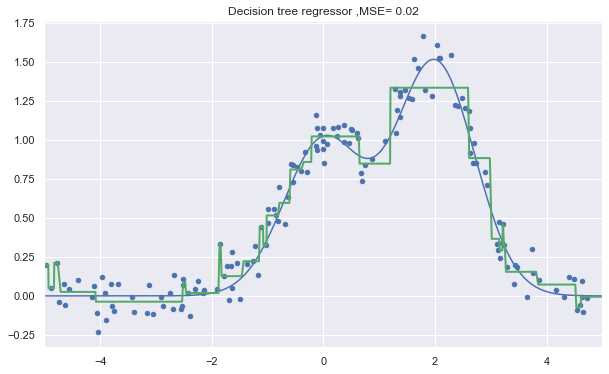

In [48]:
from sklearn.tree import DecisionTreeRegressor

n_train = 150
n_test= 1000
noise = 0.1

def f(x):
    x= x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(- (x-2) ** 2)


def generate(n_samples,noise):
    X = np.random.rand(n_samples) * 10 -5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X-2) ** 2) + np.random.normal(0.0,noise,n_samples)
    X = X.reshape((n_samples,1))
    return X,y

X_train, y_train = generate(n_samples=n_train, noise= noise)
X_test,y_test = generate(n_samples=n_test, noise= noise)

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train,y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train,y_train, c='b', s=20)
plt.plot(X_test,reg_tree_pred,'g',lw=2)

plt.xlim([-5,5])

plt.title("Decision tree regressor ,MSE= %.2f" % (np.sum((y_test - reg_tree_pred) ** 2)/ n_test))

#### 最近邻方法

最近邻方法（K 近邻或 k-NN）
- 一个非常流行的分类方法
- 也可以用于回归问题

#### 在最近邻方法中，为了对测试集中的每个样本进行分类，需要依次进行以下操作：
- 计算训练集中每个样本之间的距离。
- 从训练集中选取 k 个距离最近的样本。
- 测试样本的类别将是它 k 个最近邻中最常见的分类。